In [ ]:
#| hide
import matplotlib.pylab as plt
import numpy as np
import matplotlib as mpl
from scipy import stats

# WATERCOLOR

> Painting Hydro simulations using Spectral Population Synthesis

## Installation

Temporary installation: 
```sh
pip install git+https://github.com/nesar/watercolor.git
```
Future:
```sh
pip install watercolor
```

## Simple implementation

In [ ]:
from watercolor.paint import photometry_from_catalog

#### First we load the galaxy catalog. The main physical quantities required for painting the colors are the metallicities, stellar mass and age of the star particles of a galaxy. 

In [ ]:
galaxy_star_catalog_file='../watercolor/data/test_hacc_stellar_catalog/Gal_z0_hbin.txt' # HACC galaxy catalog
final_sed_mJy, final_wave_um, lsst_mags, spherex_mags, cosmos_mags = photometry_from_catalog(galaxy_star_catalog_file)

Number of galaxies: 200


#### The single-line command provides the SEDs and magnitudes from LSST, SPHEREx and COSMOS filters

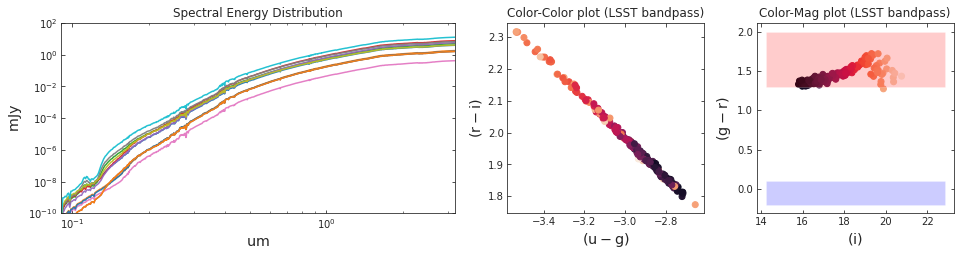

In [ ]:
# Plotting SEDs and LSST colors
f, ax = plt.subplots(1, 3, figsize=(16, 3.5), gridspec_kw={'width_ratios': [2, 1, 1]})

ax[0].set_title('Spectral Energy Distribution')
ax[1].set_title('Color-Color plot (LSST bandpass)')
ax[2].set_title('Color-Mag plot (LSST bandpass)')


np.random.seed(2)
for gal_id in np.random.randint(0, final_sed_mJy.shape[0], 12):
    ax[0].plot(final_wave_um[gal_id], final_sed_mJy[gal_id], label=str(gal_id), alpha=0.94)

ax[0].set_xlim(0.09, 3.2)
ax[0].set_ylim(1e-10, 1e2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel(r'${\rm um}$', fontsize = 'x-large')
ax[0].set_ylabel(r'${\rm mJy}}$', fontsize = 'x-large')
# ax[0].legend(fontsize='x-large', ncol=3, title='Galaxy number')
    
u, g, r, i, z, Y = lsst_mags.T

ax[1].scatter(u-g, r-i, c=Y)
ax[1].set_xlabel(r'${\rm (u-g)}$', fontsize = 'x-large')
ax[1].set_ylabel(r'${\rm (r-i)}$', fontsize = 'x-large')

ax[2].scatter(i, g-r, c=u)
ax[2].set_xlabel(r'${\rm (i)}$', fontsize = 'x-large')
ax[2].set_ylabel(r'${\rm (g-r)}$', fontsize = 'x-large')
# ax[2].axhline(y=1.3, color='red')
# ax[2].axhline(y=0.1, color='blue')
ax[2].fill_between( np.linspace(0.9*i.min(), 1.1*i.max(), 100), 1.3, 2.0,  facecolor='red', alpha=0.2, interpolate=True)
ax[2].fill_between( np.linspace(0.9*i.min(), 1.1*i.max(), 100), -0.2, 0.1,  facecolor='blue', alpha=0.2, interpolate=True)

plt.show()

In [ ]:
#| hide

import pandas as pd
import seaborn as sns
import matplotlib as mpl
from getdist import plots, MCSamples
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [ ]:
#| hide

## Checking the same galaxies at different redshifts

# galaxy_star_catalog_file0='../watercolor/data/test_hacc_stellar_catalog/Z_0New.txt' # HACC galaxy catalog
# _, _, lsst_mags_0, spherex_mags_0, cosmos_mags_0 = photometry_from_catalog(galaxy_star_catalog_file0)

In [ ]:
#| hide

# galaxy_star_catalog_file02='../watercolor/data/test_hacc_stellar_catalog/Z_02New.txt' # HACC galaxy catalog
# _, _, lsst_mags_02, spherex_mags_02, cosmos_mags_02 = photometry_from_catalog(galaxy_star_catalog_file02)

In [ ]:
#| hide

dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/'
fileCSV = 'Richard_GAMA_SED_103122_median_stack_z_Mstar_bins.csv'

df = pd.read_csv(dirIn + fileCSV)

wave_csv = df['lambda_micron']
df.keys()

Index(['lambda_micron', 'f_nu_mJy_z0.05_m10.0', 'f_nu_mJy_z0.05_m10.5',
       'f_nu_mJy_z0.05_m11.0', 'f_nu_mJy_z0.1_m10.0', 'f_nu_mJy_z0.1_m10.5',
       'f_nu_mJy_z0.1_m11.0', 'f_nu_mJy_z0.15_m10.0', 'f_nu_mJy_z0.15_m10.5',
       'f_nu_mJy_z0.15_m11.0', 'f_nu_mJy_z0.2_m10.0', 'f_nu_mJy_z0.2_m10.5',
       'f_nu_mJy_z0.2_m11.0'],
      dtype='object')

(1e-05, 10.0)

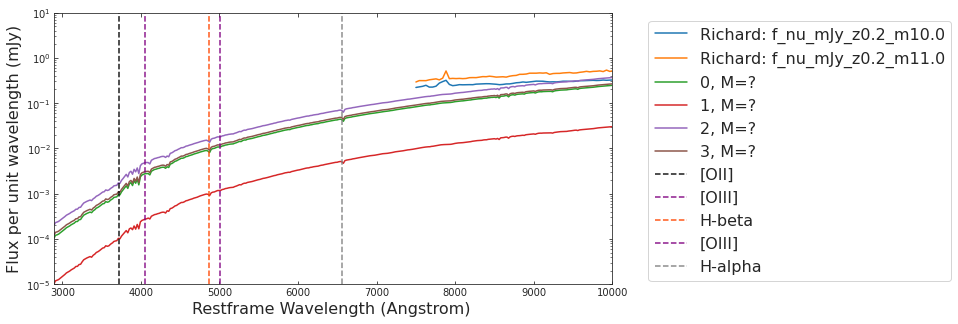

In [ ]:
#| hide

plt.figure(figsize=(10,5))

plt.plot(wave_csv*10_000 , df['f_nu_mJy_z0.2_m10.0'], label='Richard: f_nu_mJy_z0.2_m10.0');
# plt.plot(wave_csv*10_000 , df['f_nu_mJy_z0.2_m10.5'], label='Richard: f_nu_mJy_z0.2_m10.5');
plt.plot(wave_csv*10_000 , df['f_nu_mJy_z0.2_m11.0'], label='Richard: f_nu_mJy_z0.2_m11.0');


plt.plot(final_wave_um[142]*10_000 , final_sed_mJy[142], label='0, M=?');
plt.plot(final_wave_um[100]*10_000 , final_sed_mJy[100], label='1, M=?');

plt.plot(final_wave_um[20]*10_000 , final_sed_mJy[20], label='2, M=?');
plt.plot(final_wave_um[30]*10_000 , final_sed_mJy[30], label='3, M=?');



plt.ylabel('Flux per unit wavelength (mJy)', fontsize=16)
plt.xlabel('Restframe Wavelength (Angstrom) ', fontsize=16)

plt.axvline(x=3727, label = '[OII]', linestyle='dashed', alpha=0.9, color='black')
plt.axvline(x=4050, label = '[OIII]', linestyle='dashed', alpha=0.9, color='purple')
plt.axvline(x=4861, label = 'H-beta', linestyle='dashed', alpha=0.9, color='orangered')
plt.axvline(x=5007, label = '[OIII]', linestyle='dashed', alpha=0.9, color='purple')
plt.axvline(x=6563, label = 'H-alpha', linestyle='dashed', alpha=0.9, color='gray')

plt.yscale('log')
plt.legend(ncol=1, fontsize=16 , bbox_to_anchor=(1.05, 1.0), loc='upper left')

# plt.xlim(8e2, 2e4)
plt.xlim(2900, 10000)
plt.ylim(1e-5, 1e1)

In [ ]:
#| hide 

# u0, g0, r0, i0, z0, Y0 = lsst_mags_0.T
# u02, g02, r02, i02, z02, Y02 = lsst_mags_02.T


# # Plotting SEDs and LSST colors
# f, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.scatter(g-r, r-i, c='g', label='z=0 v1', alpha=0.5)
# ax.scatter(g0-r0, r0-i0, c='r', label='z=0 v2', alpha=0.5)
# ax.scatter(g02-r02, r02-i02, c='blue', label='z=0.2 v2', alpha=0.5)

# ax.set_xlabel(r'${\rm (g-r)}$', fontsize = 'x-large')
# ax.set_ylabel(r'${\rm (r-i)}$', fontsize = 'x-large')

# plt.legend()

# plt.show()


In [ ]:
#| hide 

# mpl.rcParams["axes.labelsize"] = 32

# df = pd.DataFrame(np.array([u0-g0, g0-r0, r0-i0, i0-z0, z0-Y0, i0]).T, 
#                             columns=['u-g', 'g-r','r-i','i-z', 'z-Y', 'i']);


# gr = sns.PairGrid(df);

# gr.map_lower(plt.scatter);
# gr.map_upper(sns.kdeplot);
# # gr.map_upper(hide_current_axis)
# gr.map_diag(sns.histplot, kde=True, stat='density', bins=20);

# _ = gr.add_legend(fontsize=40)

# plt.show()

In [ ]:
#| hide 

## Compare with observational data

def loadTest(dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    Testset = 'OBSuq'
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [ ]:
#| hide 

X_test, y_test, X_err, label_test = loadTest()

In [ ]:
#| hide 

y_test.min(), y_test.max(), y_test.shape, X_test.shape

(7.926745e-06, 7.01, (4339,), (4339, 5))

In [ ]:
#| hide 

z_cond = np.where(y_test < 0.3)
X_test = X_test[z_cond]
y_test = y_test[z_cond]
X_err = X_err[z_cond]
label_test = label_test[z_cond]

In [ ]:
#| hide 

y_test.min(), y_test.max(), y_test.shape, X_test.shape

(7.926745e-06, 0.2999236, (847,), (847, 5))

In [ ]:
#| hide 

if True: 
    df_testSDSS = pd.DataFrame()
    SDSS_select = np.where(label_test == 0)

    # Add columns
    df_testSDSS['u-g'] = X_test[SDSS_select][:, 0]
    df_testSDSS['g-r'] = X_test[SDSS_select][:, 1]
    df_testSDSS['r-i'] = X_test[SDSS_select][:, 2]
    df_testSDSS['i-z'] = X_test[SDSS_select][:, 3]
    df_testSDSS['mag(i)'] = X_test[SDSS_select][:, 4]
#     df_testSDSS['redshift'] = y_test[SDSS_select][:]


    df_testVIPERS = pd.DataFrame()
    VIPERS_select = np.where(label_test == 1)

    # Add columns
    df_testVIPERS['u-g'] = X_test[VIPERS_select][:, 0]
    df_testVIPERS['g-r'] = X_test[VIPERS_select][:, 1]
    df_testVIPERS['r-i'] = X_test[VIPERS_select][:, 2]
    df_testVIPERS['i-z'] = X_test[VIPERS_select][:, 3]
    df_testVIPERS['mag(i)'] = X_test[VIPERS_select][:, 4]
#     df_testVIPERS['redshift'] = y_test[VIPERS_select][:]



    df_testDEEP2 = pd.DataFrame()
    DEEP2_select = np.where(label_test == 3)

    # Add columns
    df_testDEEP2['u-g'] = X_test[DEEP2_select][:, 0]
    df_testDEEP2['g-r'] = X_test[DEEP2_select][:, 1]
    df_testDEEP2['r-i'] = X_test[DEEP2_select][:, 2]
    df_testDEEP2['i-z'] = X_test[DEEP2_select][:, 3]
    df_testDEEP2['mag(i)'] = X_test[DEEP2_select][:, 4]
#     df_testDEEP2['redshift'] = y_test[DEEP2_select][:]

    
    df_hydro = pd.DataFrame()
    df_hydro['u-g'] = u-g
    df_hydro['g-r'] = g-r
    df_hydro['r-i'] = r-i
    df_hydro['i-z'] = i-z
#     df_hydro['z-Y'] = z0-Y0
    df_hydro['mag(i)'] = i

Removed no burn in
Removed no burn in
Removed no burn in


/home/nramachandra/anaconda3/envs/env_jax/lib/python3.9/site-packages/getdist/mcsamples.py:495: RuntimeWarning: divide by zero encountered in double_scalars
  mult_max = (self.mean_mult * self.numrows) / min(self.numrows // 2, 500)


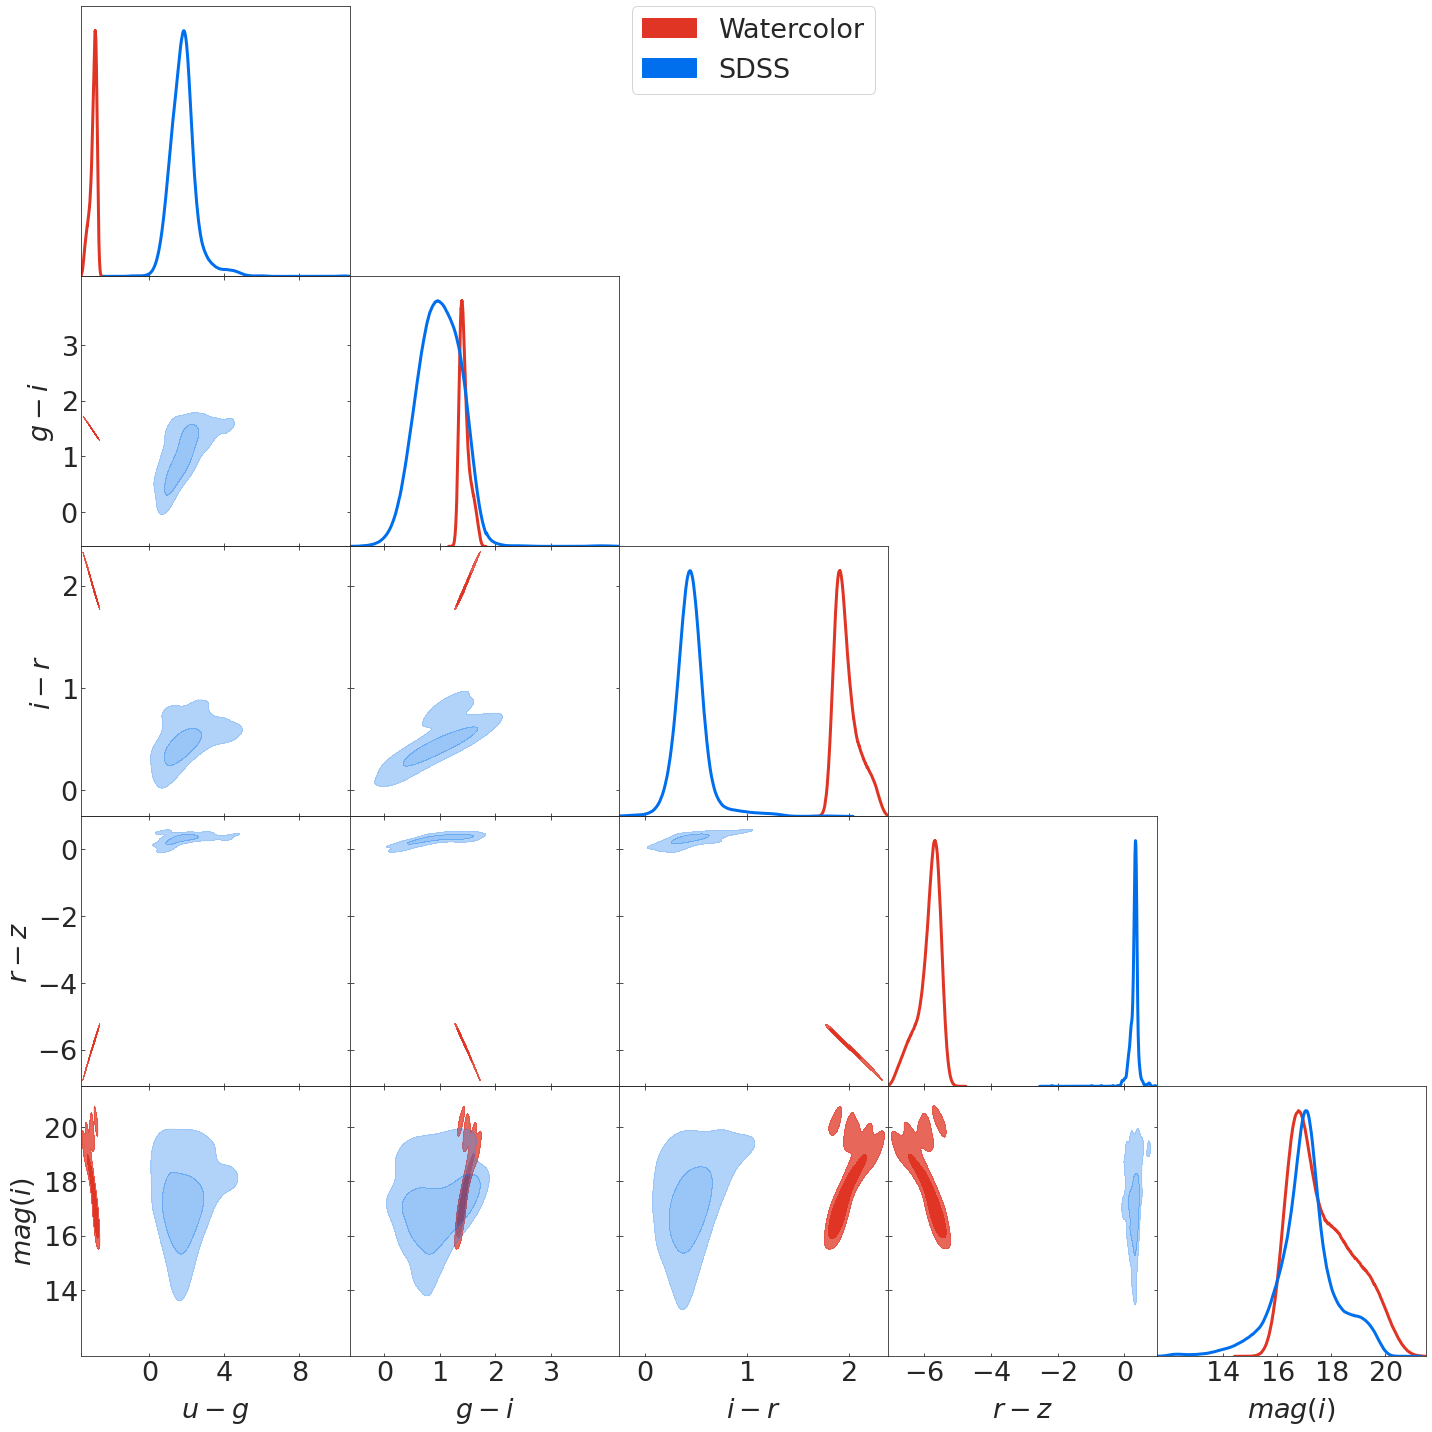

In [ ]:
#| hide 

allLabels = ['u-g', 'g-i', 'i-r', 'r-z', 'mag(i)']
line_labels = ['Synthetic', 'VIPERS', 'SDSS', 'Watercolor']

s2 = df_testVIPERS.values 
samples2 = MCSamples(samples=s2, names= allLabels , labels=allLabels, label = line_labels[1])

s3 = df_testSDSS.values 
samples3 = MCSamples(samples=s3, names= allLabels , labels=allLabels, label = line_labels[2])

s0 = df_hydro.values
samples0 = MCSamples(samples=s0, names= allLabels , labels=allLabels, label = line_labels[3])


g = plots.get_subplot_plotter(subplot_size=4)
g.settings.axes_fontsize=27
g.settings.axes_labelsize = 27
g.settings.legend_fontsize = 27
g.settings.fontsize = 27
g.settings.alpha_filled_add=0.4
g.settings.solid_contour_palefactor = 0.25
g.settings.num_plot_contours = 2

# g.triangle_plot([samples0, samples2, samples3], allLabels , filled=True, contour_lws=3) 
g.triangle_plot([samples0, samples3], allLabels , filled=True, contour_lws=3) 

plt.show()

In [ ]:
#| hide

# galaxy_star_catalog_file0='../watercolor/data/test_hacc_stellar_catalog/Gal_Z0.txt' # HACC galaxy catalog
# _, _, lsst_mags_0, spherex_mags_0, cosmos_mags_0 = photometry_from_catalog(galaxy_star_catalog_file0)

In [ ]:
#| hide

# galaxy_star_catalog_file02='../watercolor/data/test_hacc_stellar_catalog/Gal_Z02.txt' # HACC galaxy catalog
# _, _, lsst_mags_02, spherex_mags_02, cosmos_mags_02 = photometry_from_catalog(galaxy_star_catalog_file02)

In [ ]:
#| hide

# galaxy_star_catalog_file1='../watercolor/data/test_hacc_stellar_catalog/Gal_Z1.txt' # HACC galaxy catalog
# _, _, lsst_mags_1, spherex_mags_1, cosmos_mags_1 = photometry_from_catalog(galaxy_star_catalog_file1)

In [ ]:
#| hide

# galaxy_star_catalog_file2='../watercolor/data/test_hacc_stellar_catalog/Gal_Z2.txt' # HACC galaxy catalog
# _, _, lsst_mags_2, spherex_mags_2, cosmos_mags_2 = photometry_from_catalog(galaxy_star_catalog_file2)

In [ ]:
#| hide

# galaxy_star_catalog_file3='../watercolor/data/test_hacc_stellar_catalog/Gal_Z3.txt' # HACC galaxy catalog
# _, _, lsst_mags_3, spherex_mags_3, cosmos_mags_3 = photometry_from_catalog(galaxy_star_catalog_file3)

In [ ]:
#| hide 

# u0, g0, r0, i0, z0, Y0 = lsst_mags_0.T
# u02, g02, r02, i02, z02, Y02 = lsst_mags_02.T
# u1, g1, r1, i1, z1, Y1 = lsst_mags_1.T
# u2, g2, r2, i2, z2, Y2 = lsst_mags_2.T
# u3, g3, r3, i3, z3, Y3 = lsst_mags_3.T

In [ ]:
#| hide 

# # Plotting SEDs and LSST colors
# f, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.scatter(g0-r0, r0-i0, c='r', label='z=0', alpha=0.5)
# ax.scatter(g1-r1, r1-i1, c='g', label='z=1', alpha=0.5)
# ax.scatter(g2-r2, r2-i2, c='b', label='z=2', alpha=0.5)
# ax.scatter(g3-r3, r3-i3, c='k', label='z=3', alpha=0.5)
# # ax.scatter(g02-r02, r02-i02, c='brown', label='z=0.2')

# ax.set_xlabel(r'${\rm (g-r)}$', fontsize = 'x-large')
# ax.set_ylabel(r'${\rm (r-i)}$', fontsize = 'x-large')

# plt.legend()

# plt.show()

In [ ]:
#| hide 

# # Plotting SEDs and LSST colors
# f, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.scatter(g0-r0, i0, c='r', label='z=0', alpha=0.5)
# ax.scatter(g1-r1, i1, c='g', label='z=1', alpha=0.5)
# ax.scatter(g2-r2, i2, c='b', label='z=2', alpha=0.5)
# ax.scatter(g3-r3, i3, c='k', label='z=3', alpha=0.5)
# # ax.scatter(g02-r02, r02-i02, c='brown', label='z=0.2')

# ax.set_xlabel(r'${\rm (g-r)}$', fontsize = 'x-large')
# ax.set_ylabel(r'${\rm (i)}$', fontsize = 'x-large')

# plt.legend()

# plt.show()

In [ ]:
#| hide 

# nbins=17
# # Plotting SEDs and LSST colors
# f, ax = plt.subplots(1, 3, figsize=(16, 4))


# H, bins = np.histogram(i0, bins=nbins, range=(7, 15))
# ax[0].plot(bins[:-1],H/H.max(), label='z=0')

# H, bins = np.histogram(i02, bins=nbins, range=(7, 15))
# ax[0].plot(bins[:-1],H/H.max(), label='z=0.2')

# H, bins = np.histogram(i1, bins=nbins, range=(7, 15))
# ax[0].plot(bins[:-1],H/H.max(), label='z=1')

# H, bins = np.histogram(i2, bins=nbins, range=(7, 15))
# ax[0].plot(bins[:-1],H/H.max(), label='z=2')

# H, bins = np.histogram(i3, bins=nbins, range=(7, 15))
# ax[0].plot(bins[:-1],H/H.max(), label='z=2')


# ax[0].set_ylabel(r'${\rm P(i)}$', fontsize = 'x-large')
# ax[0].set_xlabel(r'${\rm i}$', fontsize = 'x-large')

# ####################

# H, bins = np.histogram(g0-r0, bins=nbins, range=(0, 1.5))
# ax[1].plot(bins[:-1],H/H.max(), label='z=0')

# H, bins = np.histogram(g02-r02, bins=nbins, range=(0, 1.5))
# ax[1].plot(bins[:-1],H/H.max(), label='z=0.2')

# H, bins = np.histogram(g1-r1, bins=nbins, range=(0, 1.5))
# ax[1].plot(bins[:-1],H/H.max(), label='z=1')

# H, bins = np.histogram(g2-r2, bins=nbins, range=(0, 1.5))
# ax[1].plot(bins[:-1],H/H.max(), label='z=2')

# H, bins = np.histogram(g3-r3, bins=nbins, range=(0, 1.5))
# ax[1].plot(bins[:-1],H/H.max(), label='z=2')


# ax[1].set_ylabel(r'${\rm P(g-r)}$', fontsize = 'x-large')
# ax[1].set_xlabel(r'${\rm g-r}$', fontsize = 'x-large')


# ####################

# H, bins = np.histogram(u0-g0, bins=nbins, range=(-3, 1.5))
# ax[2].plot(bins[:-1],H/H.max(), label='z=0')

# H, bins = np.histogram(u02-g02, bins=nbins, range=(-3, 1.5))
# ax[2].plot(bins[:-1],H/H.max(), label='z=0.2')

# H, bins = np.histogram(u1-g1, bins=nbins, range=(-3, 1.5))
# ax[2].plot(bins[:-1],H/H.max(), label='z=1')

# H, bins = np.histogram(u2-g2, bins=nbins, range=(-3, 1.5))
# ax[2].plot(bins[:-1],H/H.max(), label='z=2')

# H, bins = np.histogram(u3-g3, bins=nbins, range=(-3, 1.5))
# ax[2].plot(bins[:-1],H/H.max(), label='z=2')


# ax[2].set_ylabel(r'${\rm P(u-g)}$', fontsize = 'x-large')
# ax[2].set_xlabel(r'${\rm u-g}$', fontsize = 'x-large')


# ####################



# ax[0].legend()

# plt.show()

In [ ]:
#| hide

# import watercolor
# from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
# from watercolor.calculate_csp import calc_fluxes_for_galaxy
# from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE
# from watercolor.dust_attenuation import spectrum_dusted, log_total_stellar_metal, log_total_stellar_mass
# from watercolor.cosmic_distance_effects import combine_redshift_and_dimming_effect
# from watercolor.filter_convolution import load_survey_pickle, photometry_from_spectra

# import pandas as pd
# import seaborn as sns
# import matplotlib as mpl

In [ ]:
#| hide

# fof_halo_tag, if_satellite, galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, x, y, z , vx, vy, vz = load_hacc_galaxy_data(galaxy_star_catalog_file)

In [ ]:
#| hide

# print('Number of galaxies: %d'%np.unique(galaxy_tags).shape[0])

# logZ_all = np.zeros(shape=(np.unique(galaxy_tags).shape[0], ))
# logmstar_all = np.zeros(shape=(np.unique(galaxy_tags).shape[0], ))
# satellite_cond_all = np.zeros(shape=(np.unique(galaxy_tags).shape[0], ))
# u, g, r, i, z, Y = lsst_mags.T

# for galaxy_number in range(np.unique(galaxy_tags).shape[0]):
#     unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]
    

#     mstar_i = mass[galaxy_tags == unique_galaxy_tag]
#     metal_i = metal_hydro[galaxy_tags == unique_galaxy_tag]
    
    
#     if_satellite_i = if_satellite[galaxy_tags == unique_galaxy_tag]

#     logZ = log_total_stellar_metal(metal_i, mstar_i)[0]
#     logmstar = log_total_stellar_mass(mstar_i)[0]
#     satellite_cond = np.max(if_satellite_i)
    
#     logZ_all[galaxy_number] = logZ
#     logmstar_all[galaxy_number] = logmstar
#     satellite_cond_all[galaxy_number] = satellite_cond

# satellite_cond_all[satellite_cond_all !=0] = 1
    
# # if_central_str = np.array(satellite_cond_all.shape[0]*['dummy'])
# # if_central_str[satellite_cond_all !=0] = 'Sat'
# # if_central_str[satellite_cond_all ==0] = 'Cen'

In [ ]:
#| hide 

# def scatter_subset(x, y, hue, mask, **kws):
#     sns.scatterplot(x=x[mask], y=y[mask], hue=hue[mask], **kws)
    
# def hide_current_axis(*args, **kwds):
#     plt.gca().set_visible(False)

In [ ]:
#| hide 

# mpl.rcParams["axes.labelsize"] = 32

# df = pd.DataFrame(np.array([u-g, g-r, r-i, i-z, z-Y, i, logZ_all, logmstar_all, satellite_cond_all]).T, 
#                             columns=['u-g', 'g-r','r-i','i-z', 'z-Y', 'i', 'logZ', 'logmstar', 'if_satellite']);


# gr = sns.PairGrid(df, hue='if_satellite');

# gr.map_lower(plt.scatter);
# gr.map_upper(sns.kdeplot);
# # gr.map_upper(hide_current_axis)
# gr.map_diag(sns.histplot, kde=True, stat='density', bins=20);

# _ = gr.add_legend(fontsize=40)

# # plt.savefig('/lcrc/project/cosmo_ai/nramachandra/Projects/Hydro_paint/Plots/' + 'color_catalog.png')


In [ ]:
#| hide 

# u, g, r, i, z, Y = lsst_mags.T

# plt.figure(figsize=(5,5))
# plt.scatter( (g-r)[satellite_cond_all != 0], (u-g)[satellite_cond_all != 0], c='red', alpha=0.5, label='central')
# plt.scatter( (g-r)[satellite_cond_all != 1], (u-g)[satellite_cond_all != 1], c='blue', alpha=0.5, label='satellite')

# plt.xlabel(r'${\rm (g-r)}$', fontsize = 'x-large')
# plt.ylabel(r'${\rm (r-i)}$', fontsize = 'x-large')

# plt.show()

In [ ]:
#| hide 

# print(u.max(), u.min())
# print(g.max(), g.min())
# print(r.max(), r.min())
# print(i.max(), i.min())
# print(z.max(), z.min())
# print(Y.max(), Y.min())

# # # red # g-r > 1.3
# # # blue # g-r < 0.1

## Behind the scenes

#### 1. First we import the following modules of hydro_colors 

In [ ]:
import watercolor
from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.calculate_csp import calc_fluxes_for_galaxy
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE
from watercolor.dust_attenuation import spectrum_dusted, log_total_stellar_metal, log_total_stellar_mass
from watercolor.cosmic_distance_effects import combine_redshift_and_dimming_effect
from watercolor.filter_convolution import load_survey_pickle, photometry_from_spectra

#### 2. Then the galaxy-star catalog from HACC is loaded, using a unique galaxy tag, we select a galaxy

In [ ]:
fof_halo_tag, if_satellite, galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, x, y, z , vx, vy, vz = watercolor.load_sim_stellar_catalog.load_hacc_galaxy_data(galaxy_star_catalog_file)

In [ ]:
galaxy_number = 4 # Choosing one of the galaxies in the catalog
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]
print('Number of galaxies: %d'%np.unique(galaxy_tags).shape[0])

mstar_i = mass[galaxy_tags == unique_galaxy_tag]
metal_i = metal_hydro[galaxy_tags == unique_galaxy_tag]
if_satellite_i = if_satellite[galaxy_tags == unique_galaxy_tag]

logZ = log_total_stellar_metal(metal_i, mstar_i)
logmstar = log_total_stellar_mass(mstar_i)

Number of galaxies: 200


#### 3. After selecting a unique galaxy tag, we calculate the SED. This is the rest-frame SED is due to spectral emission alone, and without dust attenuation.  

In [ ]:
spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = watercolor.calculate_csp.calc_fluxes_for_galaxy(galaxy_star_catalog_file,
                                                                                                                       unique_galaxy_tag,
                                                                                                                       LIBRARY_FLUX_FILE,
                                                                                                                       LIBRARY_WAVE_FILE,
                                                                                                                       LIBRARY_AGE_FILE,
                                                                                                                       LIBRARY_METAL_FILE)

#### 4. We plot SEDs from both SSPs and CSPs

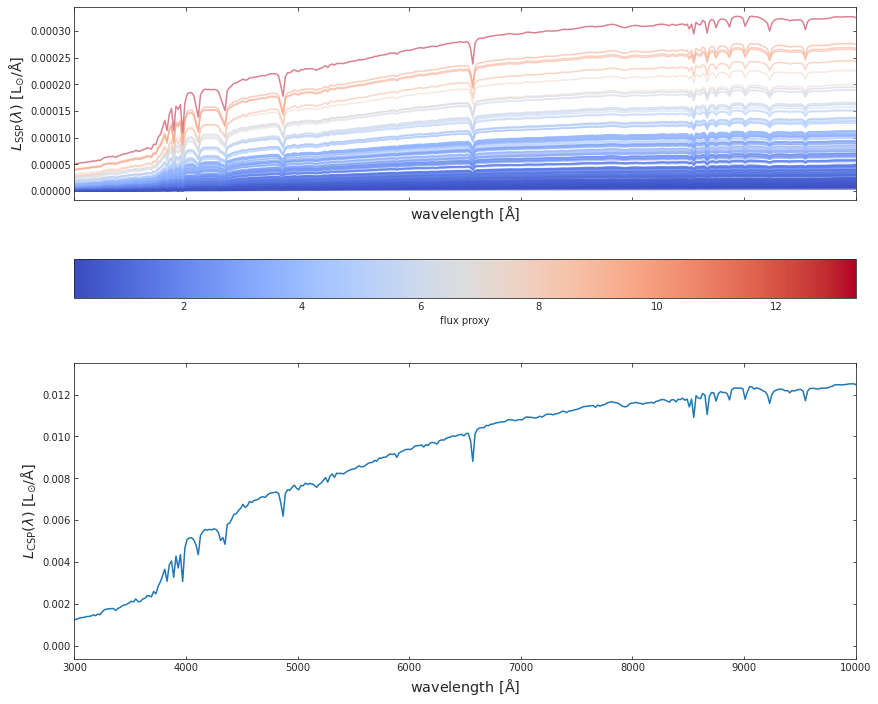

In [ ]:
fig, a = plt.subplots(2,1, figsize=(14, 12), sharex=True, sharey=False)
c_norm = mpl.colors.Normalize(vmin=np.min(flux_proxy), vmax=np.max(flux_proxy))
c_map  = mpl.cm.coolwarm

s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


for idx in range(spec_flux_ssp.shape[0]):
    
    # spec_flux_ssp[idx] = spec_ssp(age_hydro[ssp_id], metal_hydro[ssp_id], mass[ssp_id])
    a[0].plot(spec_wave_ssp, spec_flux_ssp[idx], 
              # color=s_map.to_rgba(np.log10(mass[ssp_id])), 
              color=s_map.to_rgba(flux_proxy[idx]), 
              alpha=0.5)

fig.colorbar(s_map, ax = a[0], 
             orientation = 'horizontal', 
             # label=r'stellar mass', pad=0.2)
             label=r'flux proxy', pad=0.2)
    

#####################################################################

a[1].plot(spec_wave_ssp, spec_csp)


# a[0].set_ylim(1e-9, 1e-6)
# a[0].set_yscale('log')
# a[1].set_yscale('log')
# a[1].set_xscale('log')
a[1].set_xlim(3e3, 1e4)


a[0].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[1].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[0].set_ylabel(r'$L_{\rm SSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a[1].set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')


plt.show()

#### 5. CSPs are attenuation due to dust

In [ ]:
spec_wave_csp_dusted = spectrum_dusted(spec_csp, spec_wave_ssp, logmstar, logZ, 0.01)

<matplotlib.legend.Legend>

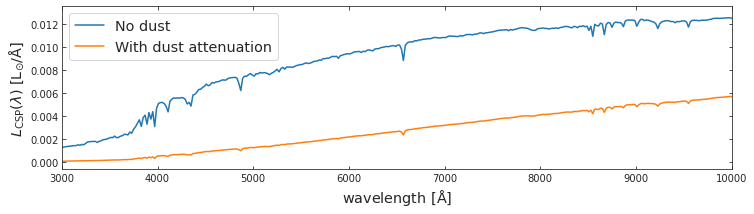

In [ ]:
f, a = plt.subplots(1, 1, figsize=(12, 3))
a.plot(spec_wave_ssp, spec_csp, label='No dust')
a.plot(spec_wave_ssp, spec_wave_csp_dusted, label='With dust attenuation')

a.set_xlim(3e3, 1e4)

a.set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a.set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a.legend(fontsize='x-large')

#### 6. The resulting dust attenuated spectra undergoes cosmic dimming and redshifting 

In [ ]:
redsh_wave, redsh_spec = combine_redshift_and_dimming_effect(wave=spec_wave_ssp, 
                                                             spec=spec_wave_csp_dusted, 
                                                             galaxy_redshift=0.001)

<matplotlib.legend.Legend>

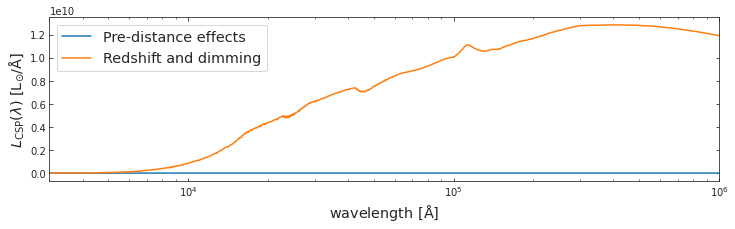

In [ ]:
f, a = plt.subplots(1, 1, figsize=(12, 3))
a.plot(spec_wave_ssp, spec_csp, label='Pre-distance effects')
a.plot(redsh_wave, redsh_spec*1e6, label='Redshift and dimming')



# a.set_xlim(3e3, 1e4)
a.set_xlim(3e3, 1e6)

a.set_xscale('log')
# a.set_yscale('log')

a.set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a.set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a.legend(fontsize='x-large')

#### 7. The final spectrum is convolved with telescope transmission curves to obtain magnitudes

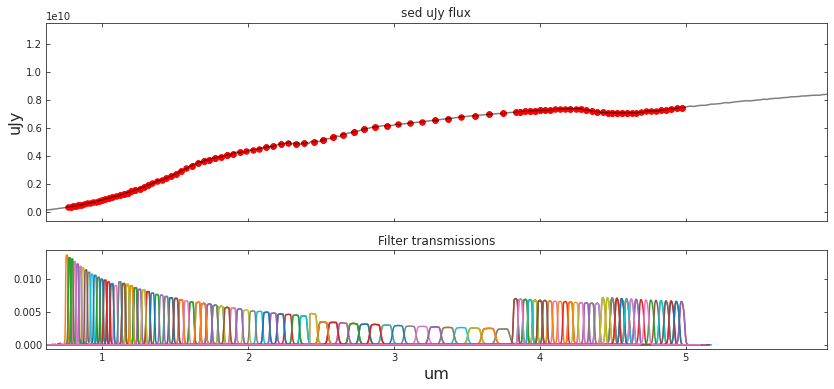

In [ ]:
##### Load survey filters 

SURVEY_STRING = 'SPHEREx'
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)

##### Compute bandpasses

# sed_um_wave = spec_wave_ssp/1e4
# sed_mJy_flux = spec_csp*1e3
sed_um_wave = redsh_wave/1e4
sed_mJy_flux = redsh_spec*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals, 
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

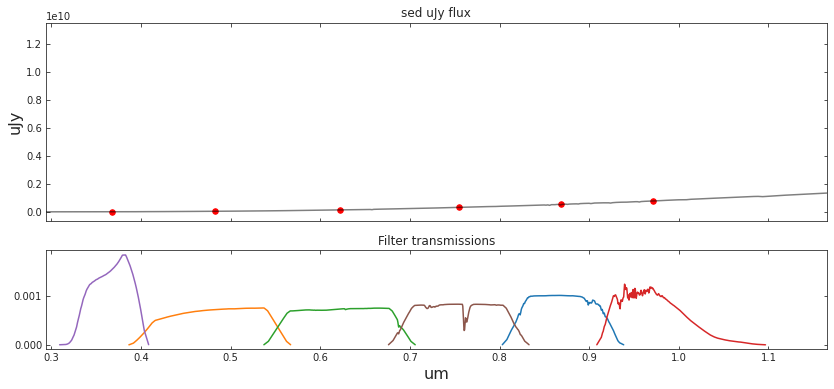

In [ ]:
##### Load survey filters 

SURVEY_STRING = 'LSST'
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)

##### Compute bandpasses

# sed_um_wave = spec_wave_ssp/1e4
# sed_mJy_flux = spec_csp*1e3
sed_um_wave = redsh_wave/1e4
sed_mJy_flux = redsh_spec*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals, 
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

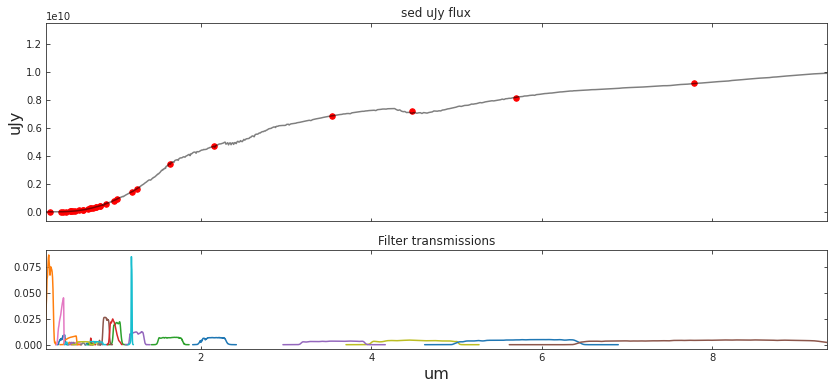

In [ ]:
##### Load survey filters 

SURVEY_STRING = 'COSMOS'
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle(SURVEY_STRING)


##### Compute bandpasses

# sed_um_wave = spec_wave_ssp/1e4
# sed_mJy_flux = spec_csp*1e3
sed_um_wave = redsh_wave/1e4
sed_mJy_flux = redsh_spec*1e3

flux_survey, appmag_ext_survey, band_fluxes_survey = photometry_from_spectra(central_wavelengths, 
                                                                          sed_um_wave, 
                                                                          sed_mJy_flux, 
                                                                          bandpass_wavs, 
                                                                          bandpass_vals, 
                                                                          bandpass_names,
                                                                          interp_kind='linear',
                                                                          plot=True,
                                                                          clip_bandpass=True)

## Profiles of the galaxies can be checked too

In [ ]:
def radial_luminosity_profile(data, 
                              num_bins=15):
    # Calculate the radial distances for each point
    
    data[:, 0] = data[:, 0] - np.mean(data[:, 0])
    data[:, 1] = data[:, 1] - np.mean(data[:, 1])
    
    r = np.sqrt(data[:, 0]**2 + data[:, 1]**2)
    
    # Bin data and sum luminosities within each bin
    bin_edges = np.linspace(0, r.max(), num_bins+1)
    luminosity, _ = np.histogram(r, bins=bin_edges, weights=data[:, 2])
    
    # Return the bin centers and corresponding luminosities
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, luminosity

def radial_mass_density_from_lum(data, 
                                 num_bins=15):
    
    data[:, 0] = data[:, 0] - np.mean(data[:, 0])
    data[:, 1] = data[:, 1] - np.mean(data[:, 1])
    
    # Calculate the radial distances for each point
    r = np.sqrt(data[:, 0]**2 + data[:, 1]**2)
    
    # Bin data and sum "masses" (luminosities) within each bin
    bin_edges = np.linspace(0, r.max(), num_bins+1)
    total_mass, _ = np.histogram(r, bins=bin_edges, weights=data[:, 3])
    
    # Calculate the area of each annulus: π(R_outer^2 - R_inner^2)
    areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    
    # Compute mass density
    mass_density = total_mass / areas
    
    # Return the bin centers and corresponding mass densities
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, mass_density

In [ ]:
gal_tag_cond = np.where(galaxy_tags == unique_galaxy_tag)

x_select =  (x[gal_tag_cond])# - np.mean(x[gal_tag_cond]))/(np.max(x[gal_tag_cond]) - np.min(x[gal_tag_cond]))
y_select =  (y[gal_tag_cond])# - np.mean(y[gal_tag_cond]))/(np.max(y[gal_tag_cond]) - np.min(y[gal_tag_cond]))

z_select = np.trapz(spec_flux_ssp, spec_wave_ssp)
m_select = mass[gal_tag_cond]

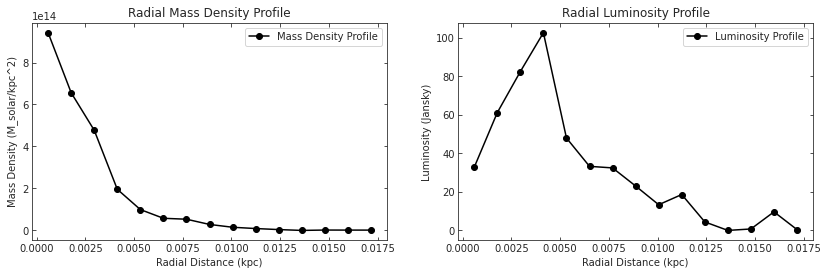

In [ ]:
bin_centers, mass_densities_direct = radial_mass_density_from_lum(np.array([x_select, y_select, z_select, m_select]).T)

# # Plotting the radial mass density profile (direct from luminosity)
f, a = plt.subplots(1, 2, figsize=(14, 4))


# Plotting the radial mass density profile
a[0].plot(bin_centers, mass_densities_direct, '-ko', label='Mass Density Profile')
a[0].set_xlabel('Radial Distance (kpc)')
a[0].set_ylabel('Mass Density (M_solar/kpc^2)')
a[0].set_title('Radial Mass Density Profile')
a[0].legend()



bin_centers, luminosities = radial_luminosity_profile(np.array([x_select, y_select, z_select, m_select]).T)

# Plotting the radial luminosity profile
a[1].plot(bin_centers, luminosities, '-ko', label='Luminosity Profile')
a[1].set_xlabel('Radial Distance (kpc)')
a[1].set_ylabel('Luminosity (Jansky)')
a[1].set_title('Radial Luminosity Profile')
a[1].legend()
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
def canvas_plot(data, 
                canvas_size = 256, 
                gauss_sigma = 16):
    
    # Create a blank canvas
    # size of the canvas for the image
    canvas = np.zeros((canvas_size, canvas_size))

    # Translate the x, y values to fit the canvas
    x_scaled = ((data[:, 0] - data[:, 0].min()) / (data[:, 0].max() - data[:, 0].min()) * canvas_size).astype(int)
    y_scaled = ((data[:, 1] - data[:, 1].min()) / (data[:, 1].max() - data[:, 1].min()) * canvas_size).astype(int)


    # Adjust the scaling to ensure values are within the bounds of the canvas
    x_scaled = np.clip(x_scaled, 0, canvas_size - 1)
    y_scaled = np.clip(y_scaled, 0, canvas_size - 1)

    # Reset the canvas
    canvas = np.zeros((canvas_size, canvas_size))

    # Place stars on the canvas using their luminosity
    for x_ind, y_ind, quant_ind in zip(x_scaled, y_scaled, data[:, 2]):
        canvas[y_ind, x_ind] += quant_ind

    # Apply a Gaussian blur to emulate the glow of stars
    blurred_canvas = gaussian_filter(canvas, sigma=gauss_sigma)
    
    return blurred_canvas

In [ ]:
blurred_canvas_lum = canvas_plot(np.array([x_select, y_select, z_select]).T)
blurred_canvas_mass = canvas_plot(np.array([x_select, y_select, m_select]).T)

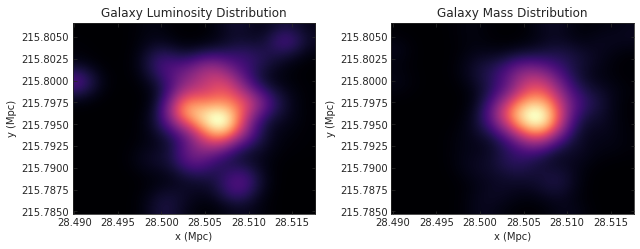

In [ ]:
f, a = plt.subplots(1, 2, figsize=(9, 6))
cmap_select = 'magma'
a[0].imshow(blurred_canvas_lum, cmap=cmap_select, origin='lower', extent=[x_select.min(), x_select.max(), y_select.min(), y_select.max()])
# a[0].colorbar(label='Luminosity (Jansky)')
a[0].set_title('Galaxy Luminosity Distribution')
a[0].set_xlabel('x (Mpc)')
a[0].set_ylabel('y (Mpc)')


a[1].imshow(blurred_canvas_mass, cmap=cmap_select, origin='lower', extent=[x_select.min(), x_select.max(), y_select.min(), y_select.max()])
# a[1].colorbar(label='Mass (Msol)')
# a[1].scatter(x_scaled, y_scaled, s=1)
a[1].set_title('Galaxy Mass Distribution')
a[1].set_xlabel('x (Mpc)')
a[1].set_ylabel('y (Mpc)')

plt.tight_layout()
plt.show()

<!-- ### One can also find luminosity profiles for the simulated galaxies -->

<!-- #### 1. First we project the luminosity on to grids -->

In [ ]:
#| hide 

# gal_tag_cond = np.where(galaxy_tags == unique_galaxy_tag)

# x_centered_scaled =  (x[gal_tag_cond] - np.min(x[gal_tag_cond]))/(np.max(x[gal_tag_cond]) - np.min(x[gal_tag_cond]))
# y_centered_scaled =  (y[gal_tag_cond] - np.min(y[gal_tag_cond]))/(np.max(y[gal_tag_cond]) - np.min(y[gal_tag_cond]))

x_centered_scaled =  (x[gal_tag_cond] - np.mean(x[gal_tag_cond]))/(np.max(x[gal_tag_cond]) - np.min(x[gal_tag_cond]))
y_centered_scaled =  (y[gal_tag_cond] - np.mean(y[gal_tag_cond]))/(np.max(y[gal_tag_cond]) - np.min(y[gal_tag_cond]))

nbins = 60


xedges = np.linspace(x_centered_scaled.min(), x_centered_scaled.max(), nbins) 
yedges = np.linspace(y_centered_scaled.min(), y_centered_scaled.max(), nbins) 


H, xedges, yedges, binnumber = stats.binned_statistic_2d(x_centered_scaled, y_centered_scaled, 
                                                         None, 'count', bins=[xedges, yedges],
                                                         expand_binnumbers=True)


grid_flux = np.zeros_like(H)

for idx, ssp_id in enumerate(gal_tag_cond[0]):
    grid_flux[binnumber[:, idx][0]-1, binnumber[:, idx][1]-1] = np.trapz(spec_flux_ssp[idx], spec_wave_ssp)

<!-- #### 2. Next we plot the stellar density and luminosity profiles -->

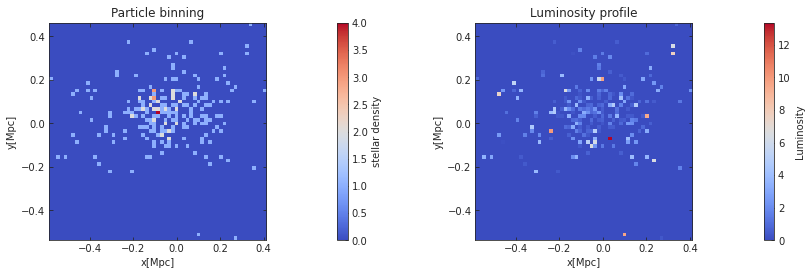

In [ ]:
#| hide 

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
c_norm = mpl.colors.Normalize(vmin=1, vmax=np.max(H))
c_map  = mpl.cm.coolwarm


ax[0].set_title('Particle binning')

im = ax[0].imshow(H, interpolation='nearest', origin='lower', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                cmap=c_map)

fig.colorbar(im, ax = ax[0], 
             orientation = 'vertical', 
             # label=r'stellar mass', pad=0.2)
             label=r'stellar density', pad=0.2)


# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=np.min(grid_flux.min()), vmax=np.max(grid_flux))
c_norm = mpl.colors.Normalize(vmin=0.004, vmax=np.max(grid_flux))

# # Pick a colormap
# c_map  = mpl.cm.magma


ax[1].set_title('Luminosity profile')
im = ax[1].imshow(grid_flux, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=c_map)

# Adding the colorbar
fig.colorbar(im, ax = ax[1], 
             orientation = 'vertical', 
             # label=r'stellar mass', pad=0.2)
             label=r'Luminosity', pad=0.2)


ax[0].set_xlabel('x[Mpc]')
ax[0].set_ylabel('y[Mpc]')
ax[1].set_xlabel('x[Mpc]')
ax[1].set_ylabel('y[Mpc]')

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')


plt.show()

<!-- ### Radial mass profile of the galaxy -->

Text(0, 0.5, 'Luminosity')

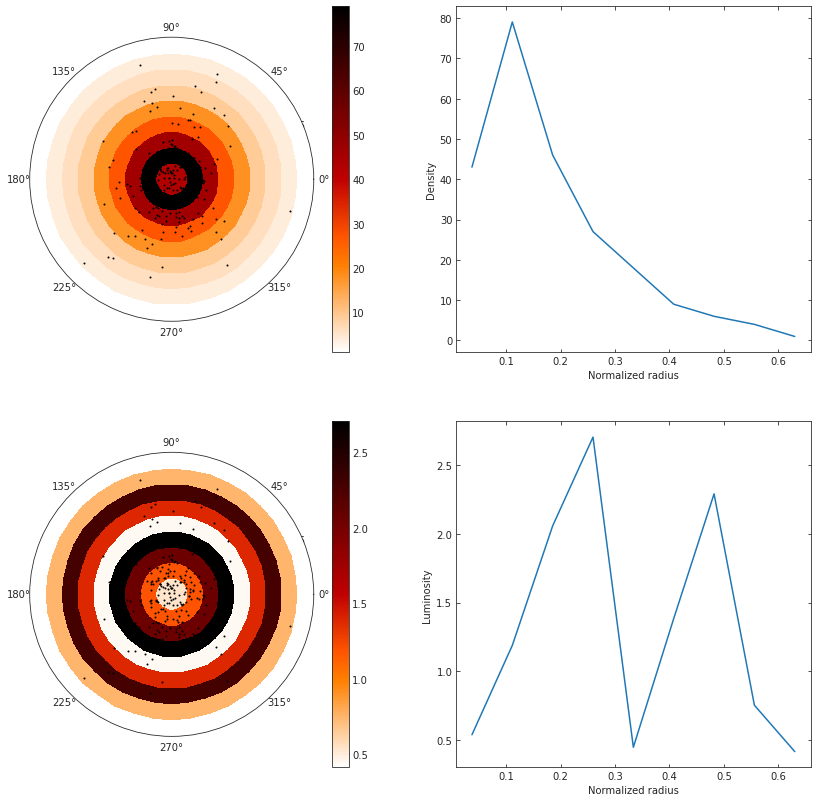

In [ ]:
#| hide 

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

radius, azimut = cart2pol(x_centered_scaled, y_centered_scaled)
azimut += np.pi

# define binning
rbins = np.linspace(0,radius.max(), 10)
abins = np.linspace(0,2*np.pi, 2)


subdivs = 40
abins2 = np.linspace(0, 2 * np.pi, (len(abins) - 1) * subdivs + 1)



#calculate histogram for mass density
# hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
hist, _, _, binnumbers = stats.binned_statistic_2d(azimut, radius, 
                                                         None, 'count', bins=[abins, rbins],
                                                         expand_binnumbers=True)


# Luminosity
grid_flux_polar = np.zeros_like(hist)

for idx, ssp_id in enumerate(gal_tag_cond[0]):
    grid_flux_polar[binnumbers[:, idx][0]-1, binnumbers[:, idx][1]-1] = np.trapz(spec_flux_ssp[idx], spec_wave_ssp)
    
    
    

A, R = np.meshgrid(abins, rbins)
A2, R2 = np.meshgrid(abins2, rbins)

# plot

fig = plt.figure(figsize=(14 , 14))
ax0 = plt.subplot(221, projection="polar")
ax1 = plt.subplot(222)

# pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
pc2 = ax0.pcolormesh(A2, R2, np.repeat(hist.T, subdivs, axis=1), cmap='gist_heat_r')
pc3 = ax0.scatter(azimut, radius, alpha=1, marker='o', s=1, color='k')
fig.colorbar(pc2, ax=ax0)

ax1.plot(0.5*(rbins[1:] + rbins[:-1]), np.sum(hist, axis=0));
ax1.set_xlabel('Normalized radius')
ax1.set_ylabel('Density')


ax2 = plt.subplot(223, projection="polar")
ax3 = plt.subplot(224)

# pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
pc3 = ax2.pcolormesh(A2, R2, np.repeat(grid_flux_polar.T, subdivs, axis=1), cmap='gist_heat_r')
pc4 = ax2.scatter(azimut, radius, alpha=1, marker='o', s=1, color='k')
fig.colorbar(pc3, ax=ax2)

ax3.plot(0.5*(rbins[1:] + rbins[:-1]), np.sum(grid_flux_polar, axis=0));
ax3.set_xlabel('Normalized radius')
ax3.set_ylabel('Luminosity')


In [ ]:
#| hide 

from scipy.interpolate import griddata
import scipy.ndimage as ndi

In [ ]:
#| hide 

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [ ]:
#| hide 

def radial_profile(data):
    y, x = np.indices((data.shape)) # first determine radii of all pixels
    
    # x = xedges[0] + ((x - np.min(x))*(xedges[1] - xedges[0])/(np.max(x) - np.min(x)))
    # y = yedges[0] + ((y - np.min(y))*(yedges[1] - yedges[0])/(np.max(y) - np.min(y)))
    
    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)    

    # radius of the image.
    r_max = np.max(r) 
    print(r.min(), r.max())

    ring_brightness, radius = np.histogram(r, weights=data, bins= np.int32(r_max/2))
    # ring_brightness, radius = np.histogram(r, weights=data, bins= 10)
    
    
    x2_prime = ((x-center[0])*(xedges[1] - xedges[0])/(x.max()-x.min()))**2
    y2_prime = ((y-center[1])*(yedges[1] - yedges[0])/(y.max()-y.min()))**2
    
    r_prime = np.sqrt(x2_prime + y2_prime)

    plt.plot(radius[1:], ring_brightness)
    # plt.xlim(np.min(r), np.max(r))
    plt.show()

0.0 41.012193308819754
0.0 41.012193308819754


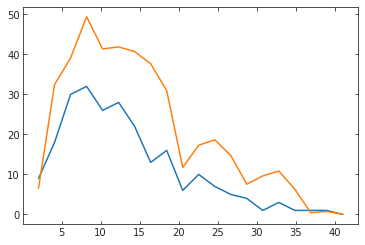

In [ ]:
#| hide 

radial_profile(H)
radial_profile(grid_flux)

Text(0, 0.5, 'Luminosity profile')

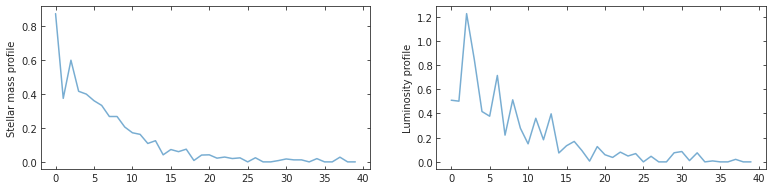

In [ ]:
#| hide 

fig, ax = plt.subplots(1, 2, figsize=(13, 3))

ax[0].plot(azimuthalAverage(H), '-', alpha=0.6)
ax[1].plot(azimuthalAverage(grid_flux), '-', alpha=0.6)

ax[0].set_ylabel('Stellar mass profile')
ax[1].set_ylabel('Luminosity profile')

<!-- ## Under the hood -->

In [ ]:
#| hide 

# # convert array into dataframe
# DF = pd.DataFrame(sample_data)

# # save the dataframe as a csv file
# DF.to_csv("data1.csv", header=['x', 'y', 'luminosity', 'mass'])